# Ventilator Waveform Anomaly Detection

## Project Overview
This project focuses on the development of a machine learning-based system to automatically detect and identify anomalies in mechanical ventilator waveforms. The goal is to assist clinicians by providing real-time, data-driven insights into patient-ventilator interaction, thereby improving patient care and clinical outcomes.

## Background & Motivation
Mechanical ventilation is a life-saving intervention in critical care. However, a significant challenge is **patient-ventilator dyssynchrony**, where the patient's respiratory efforts mismatch with the ventilator's delivery.
- **Consequences:** Dyssynchrony can lead to increased work of breathing, diaphragmatic injury, longer ventilation time, and higher mortality.
- **Current Practice:** Relies on clinicians visually inspecting waveform graphs, which is subjective, fatiguing, and may miss subtle but critical events, especially during long-term ventilation.

**Automating this process is crucial for proactive intervention and enhanced clinical decision support.**

## Objectives
1.  **Automate Detection:** To automatically flag sections of ventilator data that contain anomalous patterns indicative of dyssynchrony.
2.  **Classify Anomalies:** To identify and categorize the specific type of dyssynchrony present.
3.  **Provide Insight:** To offer clinicians a clear, interpretable output that pinpoints the timing and nature of the anomaly.

## Data
The project utilizes time-series data streams from mechanical ventilators, typically consisting of four key waveforms:
- **Flow (L/sec):** The rate of air movement into and out of the lungs.
- **Airway Pressure (Paw, cmH₂O):** The pressure in the breathing circuit.
- **Volume (mL):** The amount of air delivered per breath.
- **Muscle Pressure (Pmus, cmH₂O):** The patient's own respiratory muscle effort.

## Target Anomalies (Dyssynchronies)
The system is designed to identify several critical types of dyssynchrony, including but not limited to:
- **Ineffective Triggering:** Patient effort fails to trigger a ventilator breath.
- **Double Triggering:** A single patient effort triggers multiple ventilator breaths.
- **Flow Dysnchrony:** Insufficient ventilator flow rate for patient demand ("Shark Fin" pattern).
- **Reverse Triggering:** ventilator-triggered breath induces a patient's effort.
-

## Methodology

## Significance
This project bridges the gap between critical care medicine and data science. By leveraging machine learning to interpret complex physiological signals, it aims to create a decision-support system that can reduce clinician cognitive load, standardize ventilation management, and ultimately contribute to better patient outcomes in the ICU.

#### Incpect all patients files

In [2]:
from signal import signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.model_selection import train_test_split
import os
from pathlib import Path

def inspect_single_file(file_path, patient_id=0):
    print(f"STEP 1: INSPECTING PATIENTS FILES {patient_id}")
    print("_" * 60)

    try:
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Basic information
        print(f" File: {os.path.basename(file_path)}")
        print(f" Shape: {df.shape} (rows: {df.shape[0]}, columns: {df.shape[1]})")
        print(f" Time range: {df['time'].min():.2f} to {df['time'].max():.2f} seconds")

        # Column information
        print(f" Columns: {list(df.columns)}")
        print(f" Data types:")
        print(df.dtypes)

        # Check for missing values
        print(f" Missing values per column:")
        missing_data = df.isnull().sum()
        print(missing_data[missing_data > 0])

        # Basic statistics
        print(f" Basic statistics:")
        print(df.describe())

        # Show first few rows
        print(f" First 5 rows:")
        print(df.head())

        return df

    except Exception as e:
        return None


patient_files = list(Path("100f").glob("*.csv"))
# Loop through each file
for i, file_path in enumerate(patient_files):
    df = pd.read_csv(file_path)
    inspect_single_file(file_path, patient_id=i)


STEP 1: INSPECTING PATIENTS FILES 0
____________________________________________________________
 File: Run1.csv
 Shape: (15354, 5) (rows: 15354, columns: 5)
 Time range: 0.00 to 153.53 seconds
 Columns: ['time', 'paw', 'flow', 'vol', 'pmus']
 Data types:
time    float64
paw     float64
flow    float64
vol     float64
pmus    float64
dtype: object
 Missing values per column:
Series([], dtype: int64)
 Basic statistics:
               time           paw          flow           vol          pmus
count  15354.000000  15354.000000  15354.000000  15354.000000  15354.000000
mean      76.765000      9.284987     -0.000142      0.084936     -0.831763
std       44.324624      2.490251      0.386601      0.132017      1.374469
min        0.000000      5.849335     -0.805350     -0.024151     -5.473509
25%       38.382500      8.300838     -0.104110     -0.001411     -1.173121
50%       76.765000      8.417437     -0.022147      0.022635     -0.087534
75%      115.147500      8.985041      0.00633

##### Merge all patients in single dataFrame (df) AND add pID columns to identify patient

In [3]:
patient_files = list(Path("100f").glob("*.csv"))
all_patients_data = []

# Loop through each file
for i, file_path in enumerate(patient_files):
    df = pd.read_csv(file_path)
    df['pID'] = i
    all_patients_data.append(df)



In [4]:
if all_patients_data:
    merged_df = pd.concat(all_patients_data, ignore_index=True)
    print(f"\nMerged DataFrame shape: {merged_df.shape}")
    print(f"Unique patients: {merged_df['pID'].nunique()}")
    print(f"Columns: {list(merged_df.columns)}")

    # Show first few rows with pID
    print("\nFirst 5 rows of merged data:")
    print(merged_df.head())
    print("\nLast 5 rows of merged data:")
    print(merged_df.tail())



Merged DataFrame shape: (1745928, 6)
Unique patients: 100
Columns: ['time', 'paw', 'flow', 'vol', 'pmus', 'pID']

First 5 rows of merged data:
   time       paw      flow       vol      pmus  pID
0  0.00  8.267437  0.004503  0.000000  0.000000    0
1  0.01  8.235019 -0.025890 -0.000002 -0.000394    0
2  0.02  8.232418  0.005742 -0.000012 -0.001571    0
3  0.03  8.181379  0.005054 -0.000027 -0.003511    0
4  0.04  8.179352  0.004899 -0.000043 -0.006185    0

Last 5 rows of merged data:
           time       paw      flow       vol  pmus  pID
1745923  188.78  7.004472  0.000996 -0.013527   0.0   99
1745924  188.79  7.003815 -0.000047 -0.013528   0.0   99
1745925  188.80  7.021380  0.016381 -0.013528   0.0   99
1745926  188.81  6.986946  0.022413 -0.013529   0.0   99
1745927  188.82  6.795783  0.007876 -0.013530   0.0   99


##### Drop pmus Column from df

In [5]:
df=merged_df
df = df.drop('pmus', axis=1)
np.random.seed(42)

print(df.head())
print(df.tail())

   time       paw      flow       vol  pID
0  0.00  8.267437  0.004503  0.000000    0
1  0.01  8.235019 -0.025890 -0.000002    0
2  0.02  8.232418  0.005742 -0.000012    0
3  0.03  8.181379  0.005054 -0.000027    0
4  0.04  8.179352  0.004899 -0.000043    0
           time       paw      flow       vol  pID
1745923  188.78  7.004472  0.000996 -0.013527   99
1745924  188.79  7.003815 -0.000047 -0.013528   99
1745925  188.80  7.021380  0.016381 -0.013528   99
1745926  188.81  6.986946  0.022413 -0.013529   99
1745927  188.82  6.795783  0.007876 -0.013530   99


##### Visualize random patient data

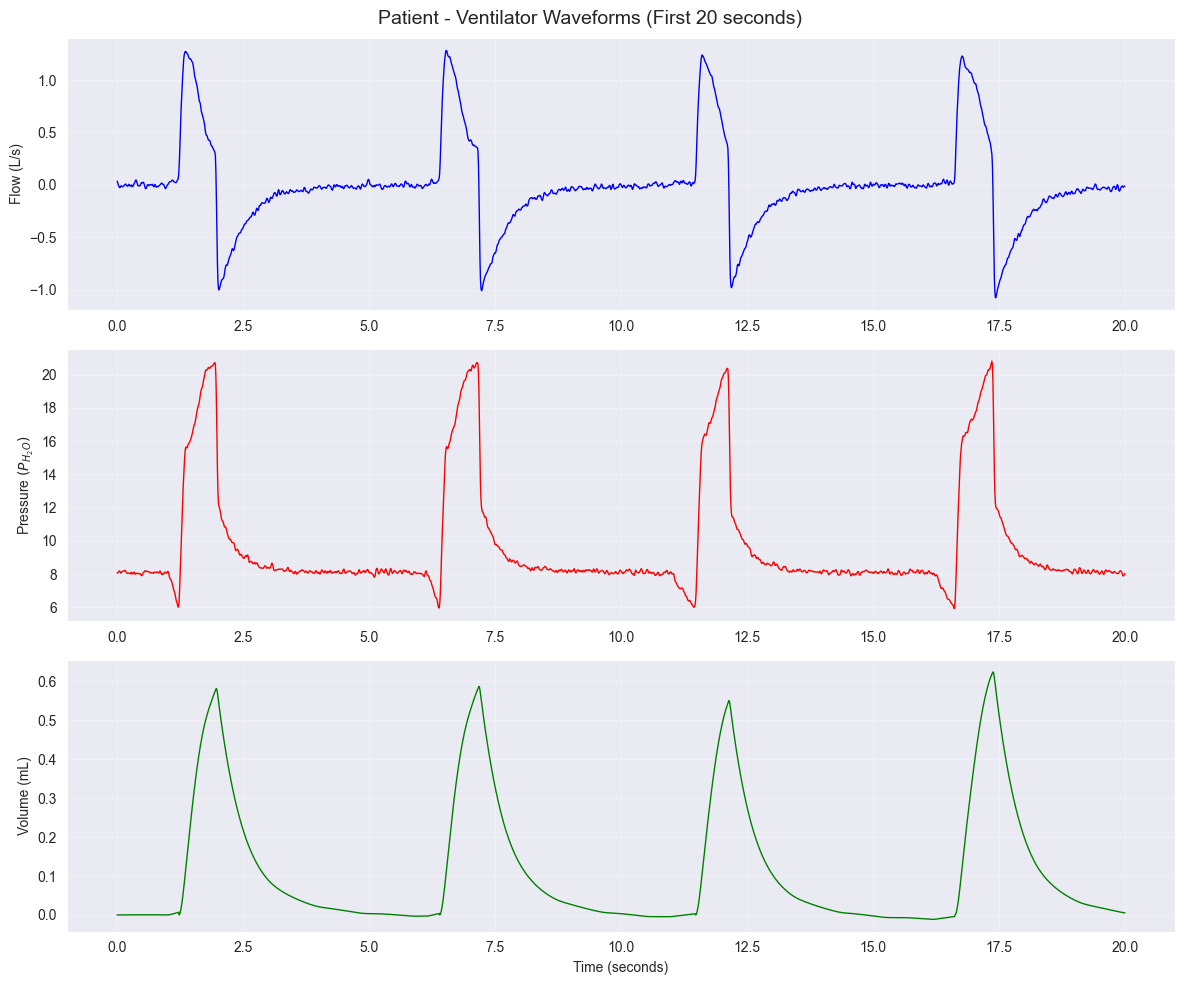

In [6]:
first_patient_df = df[df['pID']==5]

fig, axes = plt.subplots(3, 1, figsize=(12, 10))
fig.suptitle(f'Patient - Ventilator Waveforms (First 20 seconds)', fontsize=14)

# Plot each waveform
waveforms = ['flow', 'paw', 'vol']
colors = ['blue', 'red', 'green']
ylabels = ['Flow (L/s)', 'Pressure $(P_{H_2O})$', 'Volume (mL)']

for i, (waveform, color, ylabel) in enumerate(zip(waveforms, colors, ylabels)):
    if waveform in first_patient_df.columns:
        # Show only first 20 seconds for clarity
        subset = first_patient_df[first_patient_df['time'] <= 20] if 'time' in first_patient_df.columns else first_patient_df.head(1000)
        axes[i].plot(subset['time'] if 'time' in first_patient_df.columns else subset.index,
                    subset[waveform], color=color, linewidth=1)
        axes[i].set_ylabel(ylabel)
        axes[i].grid(True, alpha=0.3)


axes[-1].set_xlabel('Time (seconds)')
plt.tight_layout()
plt.show()

##### divide time by 4 segment where each segment holds 20s of each patient and hold it in annotation_data

In [7]:
annotation_data = []

for patient_id in merged_df['pID'].unique():
    patient_data = merged_df[merged_df['pID'] == patient_id].copy()
    total_duration = patient_data['time'].max()

    print(f"Patient {patient_id}: {total_duration:.1f}s total")

    # Create 4 random segments of 20 seconds each
    segments = []
    for segment_num in range(4):
        # Find random start time that allows 20-second segment
        max_start = total_duration - 20
        if max_start > 0:
            start_time = np.random.uniform(0, max_start)
            end_time = start_time + 20
        else:
            # If recording is short, use what's available
            start_time = 0
            end_time = total_duration

        # Extract segment
        segment = patient_data[
            (patient_data['time'] >= start_time) &
            (patient_data['time'] < end_time)
        ].copy()

        if len(segment) > 0:
            segment['segment_id'] = segment_num
            segment['global_segment_id'] = f"P{patient_id}_S{segment_num}"
            segment['segment_range'] = f"{start_time:.1f}-{end_time:.1f}s"
            segments.append(segment)
            print(f"  Segment {segment_num}: {start_time:.1f}-{end_time:.1f}s ({len(segment)} points)")

    # Add all segments for patient to annotation data
    if segments:
        patient_segments = pd.concat(segments, ignore_index=True)
        annotation_data.append(patient_segments)

if annotation_data:
    annotation_df = pd.concat(annotation_data, ignore_index=True)

    print(f"\nANNOTATION DATASET CREATED:")
    print(f"Total patients: {annotation_df['pID'].nunique()}")
    print(f"Total segments: {annotation_df['global_segment_id'].nunique()}")
    print(f"Total data points: {len(annotation_df)}")
    print(f"Data reduction: {len(annotation_df)/len(merged_df)*100:.1f}%")
    print(annotation_df.info())


Patient 0: 153.5s total
  Segment 0: 50.0-70.0s (2000 points)
  Segment 1: 126.9-146.9s (2000 points)
  Segment 2: 97.7-117.7s (2000 points)
  Segment 3: 79.9-99.9s (2000 points)
Patient 1: 175.5s total
  Segment 0: 24.3-44.3s (2000 points)
  Segment 1: 24.3-44.3s (2000 points)
  Segment 2: 9.0-29.0s (2000 points)
  Segment 3: 134.7-154.7s (2000 points)
Patient 2: 163.5s total
  Segment 0: 86.3-106.3s (2000 points)
  Segment 1: 101.6-121.6s (2000 points)
  Segment 2: 3.0-23.0s (2000 points)
  Segment 3: 139.2-159.2s (2000 points)
Patient 3: 190.9s total
  Segment 0: 142.2-162.2s (2000 points)
  Segment 1: 36.3-56.3s (2000 points)
  Segment 2: 31.1-51.1s (2000 points)
  Segment 3: 31.3-51.3s (2000 points)
Patient 4: 177.0s total
  Segment 0: 47.8-67.8s (2000 points)
  Segment 1: 82.4-102.4s (2000 points)
  Segment 2: 67.8-87.8s (2000 points)
  Segment 3: 45.7-65.7s (2000 points)
Patient 5: 184.2s total
  Segment 0: 100.4-120.4s (2000 points)
  Segment 1: 22.9-42.9s (2000 points)
  Segme

##### Visualize random patients after divide time in 4 interval where each interval holds 20s


 Verifying random segments...


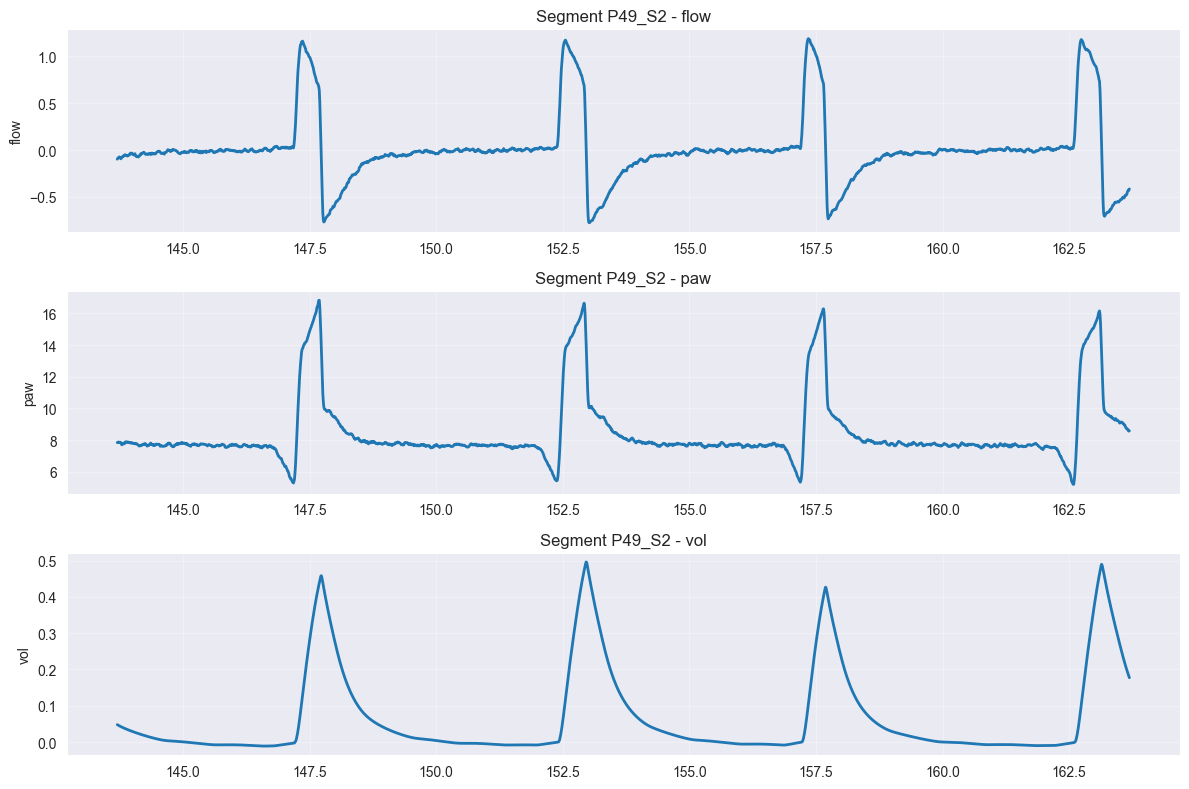

Segment P49_S2: 2000 points, time: 143.7-163.7s


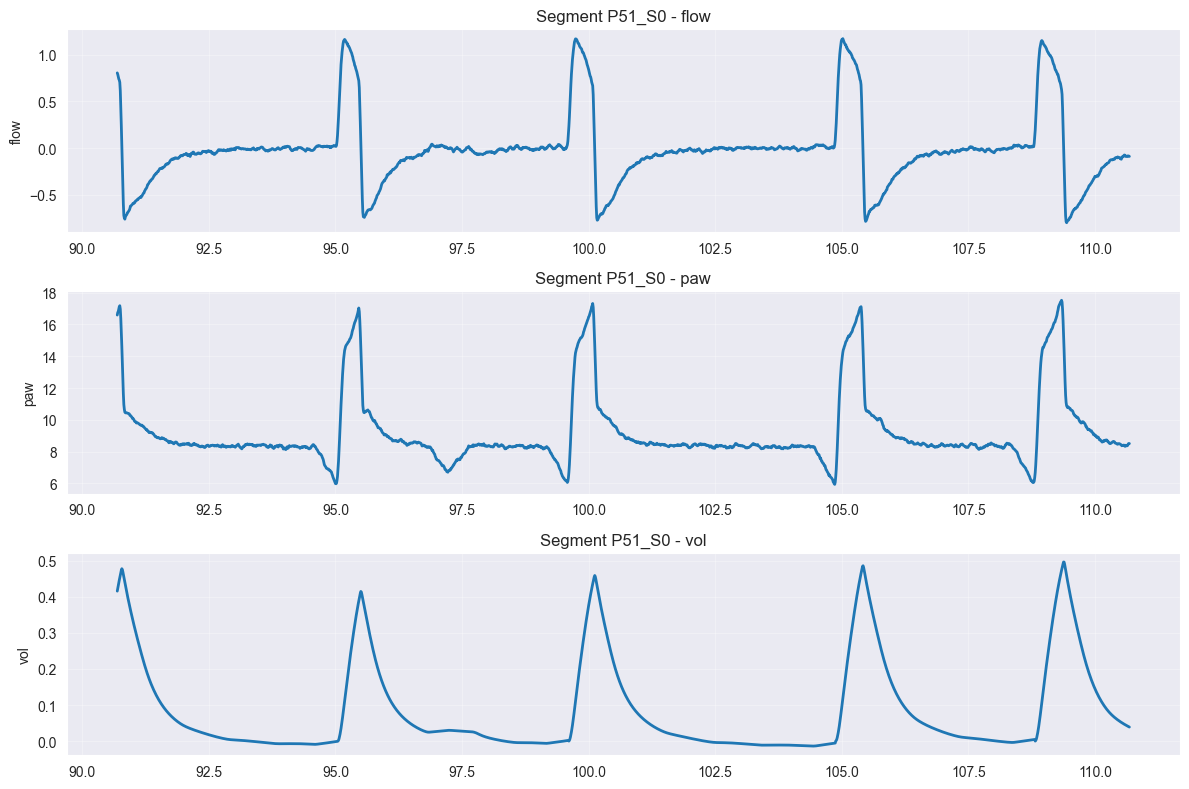

Segment P51_S0: 2000 points, time: 90.7-110.7s


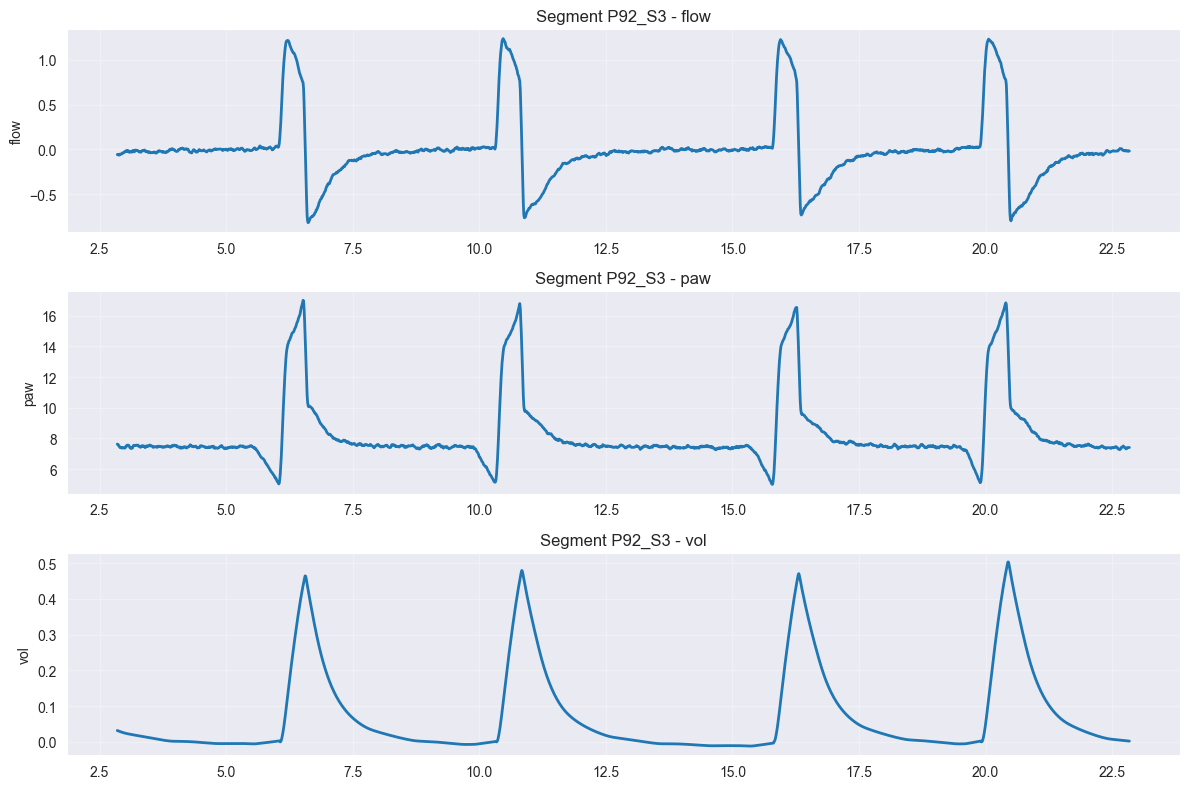

Segment P92_S3: 2000 points, time: 2.9-22.8s


In [10]:
    print("\n Verifying random segments...")
    sample_segments = np.random.choice(annotation_df['global_segment_id'].unique(), 3, replace=False)

    for seg_id in sample_segments:
        seg_data = annotation_df[annotation_df['global_segment_id'] == seg_id]
        patient_id = seg_data['pID'].iloc[0]

        plt.figure(figsize=(12, 8))
        for i, signal in enumerate(waveforms, 1):
            plt.subplot(3, 1, i)
            plt.plot(seg_data['time'], seg_data[signal], linewidth=2)
            plt.title(f'Segment {seg_id} - {signal}')
            plt.ylabel(signal)
            plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print(f"Segment {seg_id}: {len(seg_data)} points, time: {seg_data['time'].min():.1f}-{seg_data['time'].max():.1f}s")

#### Now after data is normalized and time is divided into segment and ennsuring all graph looks accurate we reduce data by 12.5% to 100k row

In [11]:
# Set target size
target_size = 100000
final_df=annotation_df
# Calculate how many points per segment we need
segments_count = final_df['global_segment_id'].nunique()
points_per_segment = target_size // segments_count

print(f"Segments: {segments_count}")
print(f"Points per segment: {points_per_segment}")

# Sample points from each segment to reach target size
reduced_data = []

for segment_id in final_df['global_segment_id'].unique():
    segment_data = final_df[final_df['global_segment_id'] == segment_id]

    if len(segment_data) <= points_per_segment:
        # Keep all points if segment is small
        reduced_data.append(segment_data)
    else:
        # Sample evenly spaced points
        indices = np.linspace(0, len(segment_data)-1, points_per_segment, dtype=int)
        sampled_segment = segment_data.iloc[indices]
        reduced_data.append(sampled_segment)

# Combine all segments
final_df = pd.concat(reduced_data, ignore_index=True)

final_df.shape

Segments: 400
Points per segment: 250


(100000, 9)

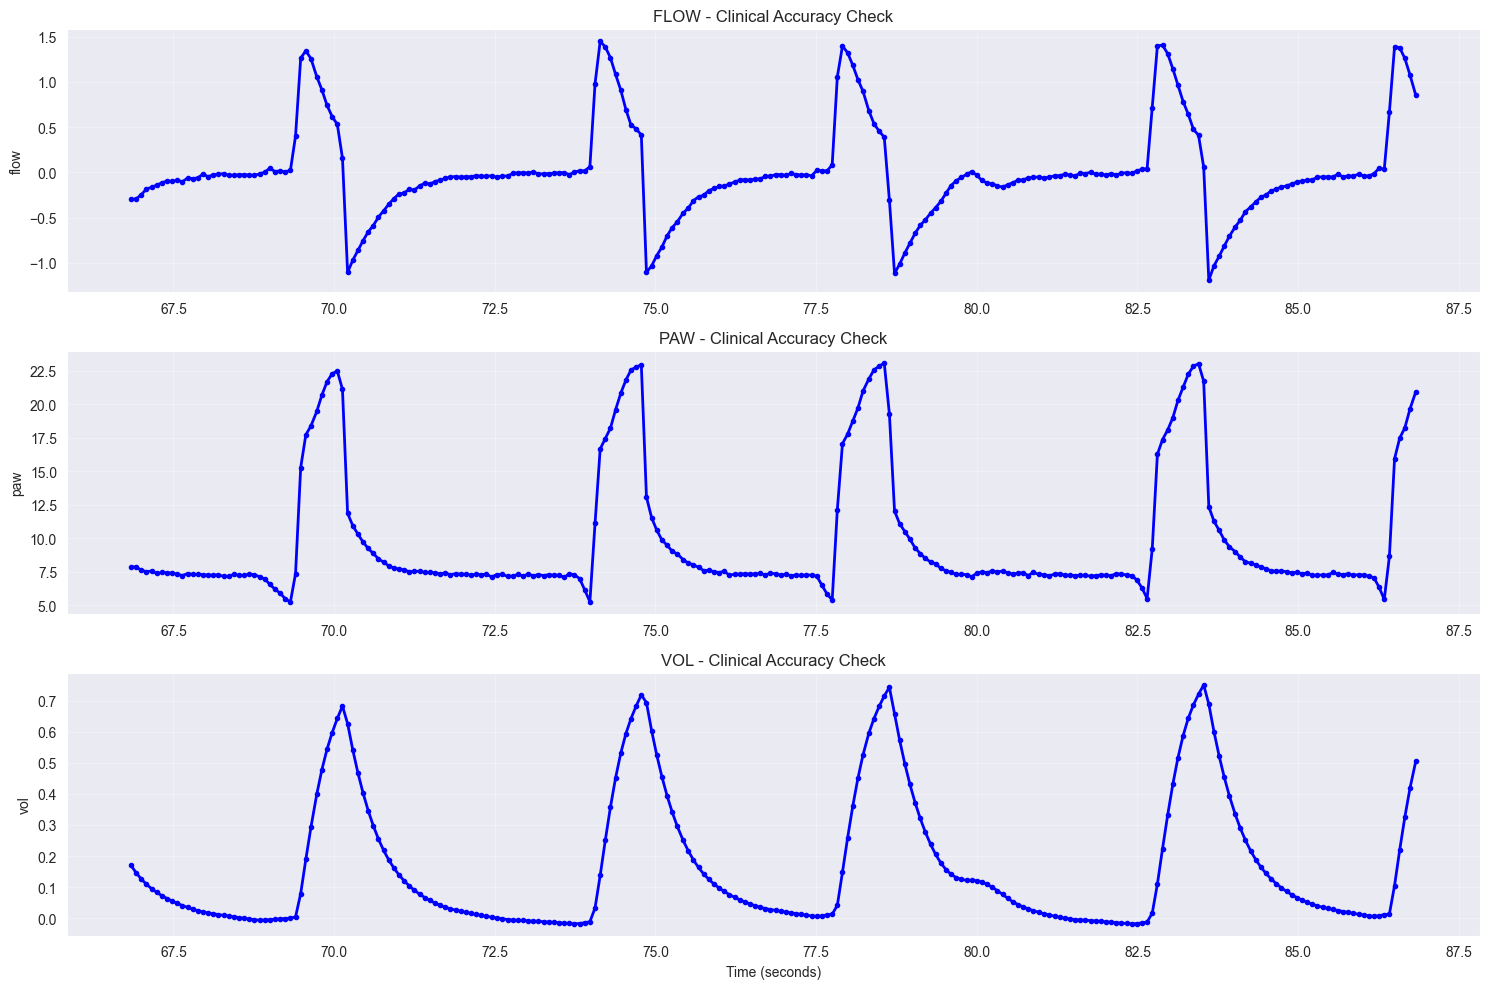

Sample segment: P10_S1


In [15]:
# Visualize to verify accuracy
sample_segment_id = np.random.choice(final_df['global_segment_id'].unique())
reduced_segment = final_df[final_df['global_segment_id'] == sample_segment_id]

plt.figure(figsize=(15, 10))

signals = ['flow', 'paw', 'vol']
for i, signal in enumerate(signals, 1):
    plt.subplot(3, 1, i)

    # Plot reduced points
    plt.plot(reduced_segment['time'], reduced_segment[signal],
             'blue', linewidth=2, marker='o', markersize=3)

    plt.title(f'{signal.upper()} - Clinical Accuracy Check')
    plt.ylabel(signal)
    plt.grid(True, alpha=0.3)

plt.xlabel('Time (seconds)')
plt.tight_layout()
plt.show()

print(f"Sample segment: {sample_segment_id}")


##### Save preprocessing data nad reduce to a new csv file

In [17]:
# Save the final dataset
output_file = f'wavesData_{len(final_df)//1000}k.csv'
final_df.to_csv(output_file, index=False)

print(f"\nSaved as: {output_file}")


Saved as: wavesData_100k.csv
